<a href="https://colab.research.google.com/github/qa21336/HousingStatisticsAnalysis-/blob/main/Merged_Data_Feature_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating each Features ability to predict Housing Affordability

Open the dataset

In [70]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/ADS Datasets/cleaned_interpolated.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Year,country,Persons,Males,Females,affordability,Started - All Dwellings,Completed - All Dwellings,mm/yyyy,employment_rate,inflation_rate,AveragePrice,SalesVolume,NewSalesVolume,OldSalesVolume
0,2001,E,49449746.00,2.416559e+07,2.528416e+07,4.500000,146770.0,129510.0,01/2001,72.7,0.9,96649.186160,717.574850,55.428144,662.146707
1,2001,E,49468872.75,2.417618e+07,2.529269e+07,4.551667,147097.5,130117.5,02/2001,72.6,0.8,96675.059120,741.808383,71.586826,670.221557
2,2001,E,49487999.50,2.418678e+07,2.530122e+07,4.603333,147425.0,130725.0,03/2001,72.6,0.9,97172.835571,995.470060,109.086826,886.383234
3,2001,E,49507126.25,2.419738e+07,2.530975e+07,4.655000,147752.5,131332.5,04/2001,72.7,1.2,98461.905336,976.658683,88.502994,888.155689
4,2001,E,49526253.00,2.420798e+07,2.531828e+07,4.706667,148080.0,131940.0,05/2001,72.7,1.7,100160.766675,1097.919162,100.482036,997.437126


Create 'Time' feature

In [71]:
monthsYears = df["mm/yyyy"]
months = list(map(lambda my: int(my.split("/")[0]), monthsYears))
years = list(map(lambda my: int(my.split("/")[1]), monthsYears))

# -1 so it's zero indexes, /12 so its in range [0, 1)
monthsReformatted = (np.array(months) - 1) / 12
time = np.array(years) + monthsReformatted

df.insert(0, "Time", time)
df = df.drop(["Year", "mm/yyyy"], axis=1)
df.head()

,Time,country,Persons,Males,Females,affordability,Started - All Dwellings,Completed - All Dwellings,employment_rate,inflation_rate,AveragePrice,SalesVolume,NewSalesVolume,OldSalesVolume
0,2001.000000,E,49449746.00,2.416559e+07,2.528416e+07,4.500000,146770.0,129510.0,72.7,0.9,96649.186160,717.574850,55.428144,662.146707
1,2001.083333,E,49468872.75,2.417618e+07,2.529269e+07,4.551667,147097.5,130117.5,72.6,0.8,96675.059120,741.808383,71.586826,670.221557
2,2001.166667,E,49487999.50,2.418678e+07,2.530122e+07,4.603333,147425.0,130725.0,72.6,0.9,97172.835571,995.470060,109.086826,886.383234
3,2001.250000,E,49507126.25,2.419738e+07,2.530975e+07,4.655000,147752.5,131332.5,72.7,1.2,98461.905336,976.658683,88.502994,888.155689
4,2001.333333,E,49526253.00,2.420798e+07,2.531828e+07,4.706667,148080.0,131940.0,72.7,1.7,100160.766675,1097.919162,100.482036,997.437126


Linear regression with features individually.

In [72]:
import numpy as np
from sklearn.feature_selection import r_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

countries = np.unique(df["country"])
for country in countries:
    print("Country: "+country)
    # Get labels for country
    countryDf = df.loc[df["country"] == country]
    affordData = np.array(countryDf["affordability"])

    for col in df.columns:
        if(col == "affordability" or col == "country"):
            continue

        colData = np.array(countryDf[col]).reshape(-1, 1)

        lr = LinearRegression()
        scores = cross_val_score(lr,
                                colData,
                                affordData,
                                cv=20,
                                scoring="neg_mean_squared_error")

        print("Feature: "+col)
        print("Average linear regression CV MSE: "+str(-1 * np.mean(scores)))
        print()
    print()

Country: E
Feature: Time
Average linear regression CV MSE: 0.21170600093353165

Feature: Persons
Average linear regression CV MSE: 0.23108265978944414

Feature: Males
Average linear regression CV MSE: 0.23091784118953665

Feature: Females
Average linear regression CV MSE: 0.23129029561577155

Feature: Started - All Dwellings
Average linear regression CV MSE: 0.6954851349581286

Feature: Completed - All Dwellings
Average linear regression CV MSE: 0.6156624865462609

Feature: employment_rate
Average linear regression CV MSE: 0.5398943765850974

Feature: inflation_rate
Average linear regression CV MSE: 0.7506566906193758

Feature: AveragePrice
Average linear regression CV MSE: 0.07326367627955135

Feature: SalesVolume
Average linear regression CV MSE: 0.6980472139231242

Feature: NewSalesVolume
Average linear regression CV MSE: 0.7106617341215157

Feature: OldSalesVolume
Average linear regression CV MSE: 0.6921117741463665


Country: W
Feature: Time
Average linear regression CV MSE: 0.519

Linear model with all features together

In [73]:
from sklearn.model_selection import train_test_split

usingAveragePrice = False

if(usingAveragePrice):
    dfReg = df
else:
    dfReg = df.drop("AveragePrice", axis=1)

lms = []
for country in countries:
    countryData = dfReg.loc[dfReg["country"] == country].drop("country", axis=1)
    countryYs = countryData.pop("affordability")
    countryXs = countryData

    X_tr, X_test, y_tr, y_test = train_test_split(countryXs,
                                                  countryYs,
                                                  test_size=0.3,
                                                  random_state=0)

    lm = LinearRegression().fit(X_tr, y_tr)
    lms.append(lm)

    print(country+" train score: "+str(lm.score(X_tr, y_tr)))
    print(country+" test score: "+str(lm.score(X_test, y_test)))

E train score: 0.9647509843366465
E test score: 0.9669915021129295
W train score: 0.9439633788316287
W test score: 0.9506917890753539


Do some plots (everything other than indep. variable is the mean)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 12 features, but LinearRegression is expecting 11 features as input.

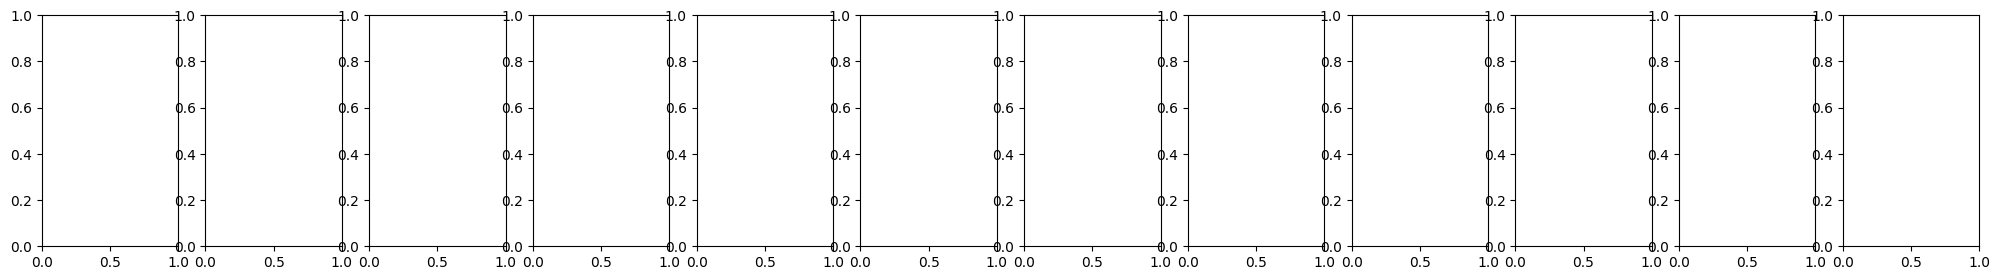

In [74]:
import matplotlib.pyplot as plt

numFeatures = len(df.columns)-2

for i, country in enumerate(countries):
    fig, axes = plt.subplots(1, numFeatures, figsize=(25, 3))

    # Get labels for country
    countryDf = (df.loc[df["country"] == country]).drop("country", axis=1)
    affordData = countryDf.pop("affordability")

    # Means
    means = np.mean(countryDf, axis=0)

    # Plot all scatters
    for j, col in enumerate(countryDf.columns):
        colData = np.array(countryDf[col]).reshape(-1, 1)

        # Model predictions
        x = np.tile(means, (len(countryDf), 1))
        x[:, j] = colData.reshape(-1,)
        preds = lms[i].predict(x)

        # Plot
        axes[j].scatter(colData, affordData)
        axes[j].set_title(country+" "+col+" vs Affordability")
        axes[j].set_xlabel(col)
        axes[j].set_ylabel("Price to Earnings Ratio")
        axes[j].plot(colData, preds)
    plt.show()



Plots but all variables vary over time

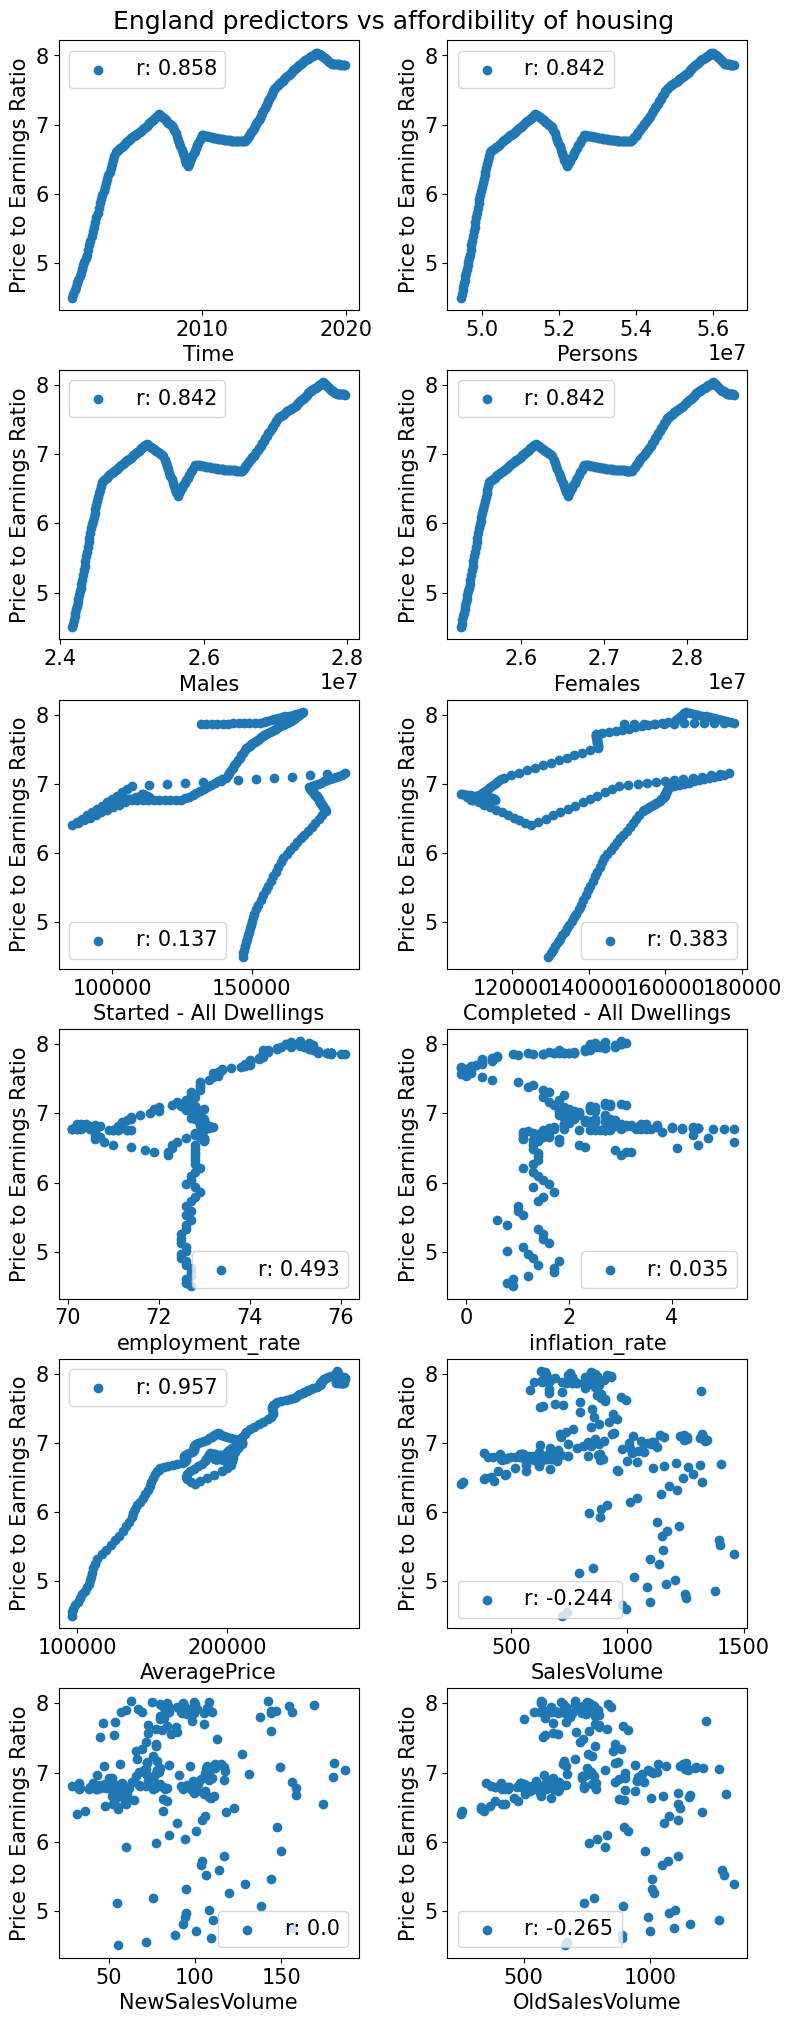

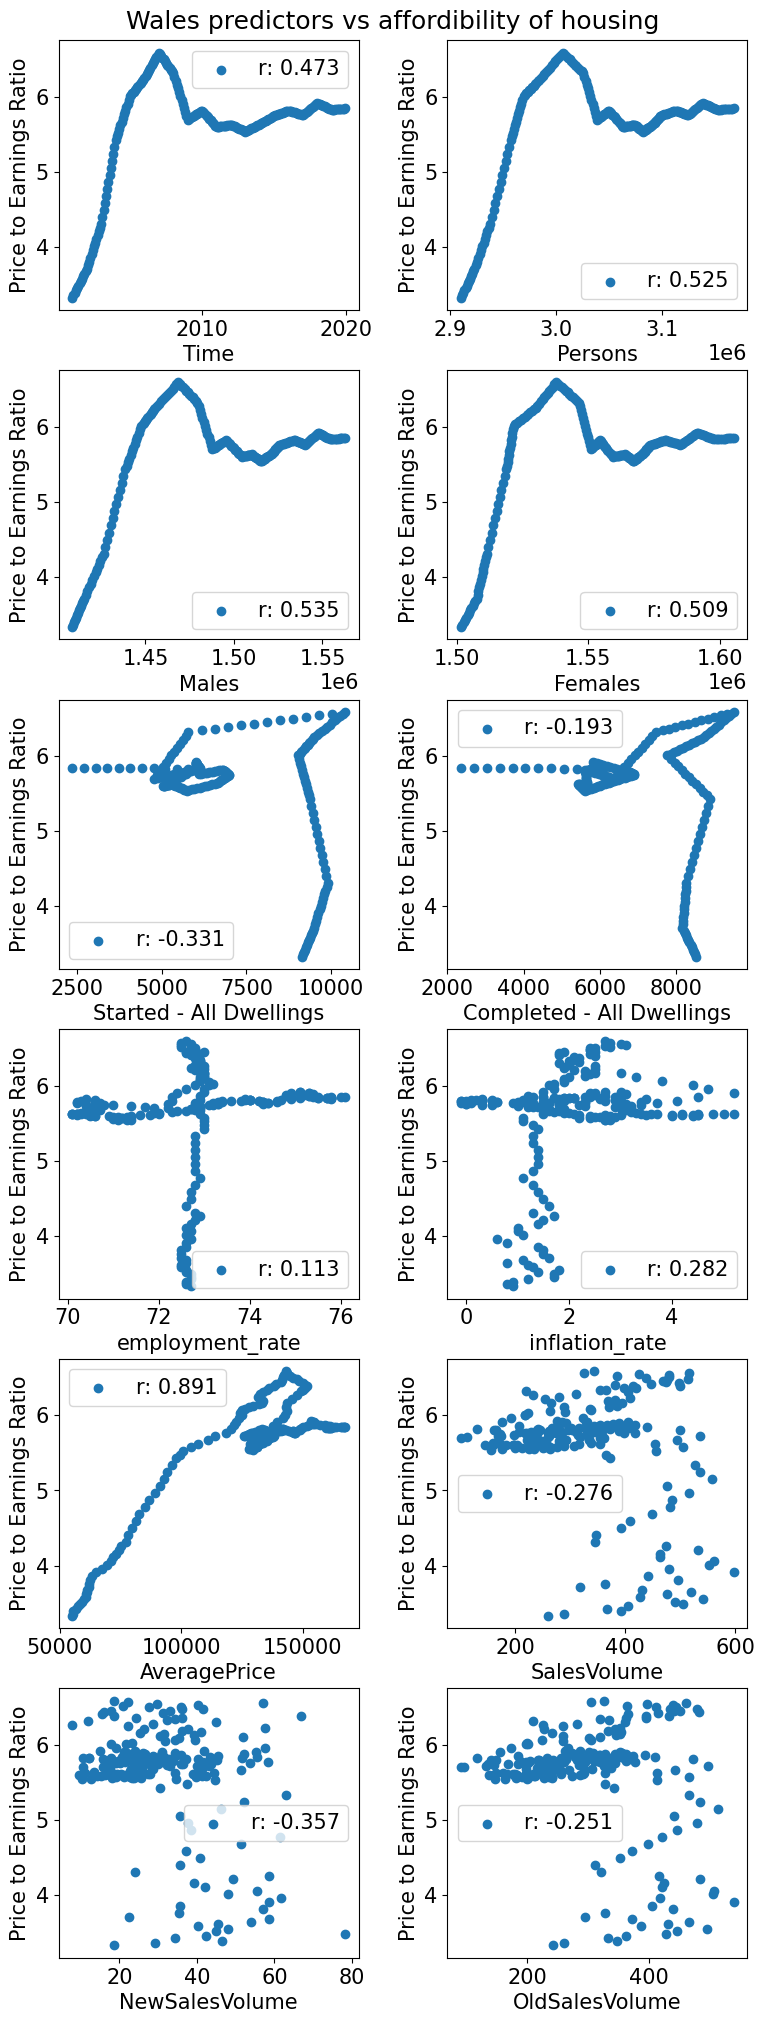

In [82]:
for i, country in enumerate(countries):
    #numCols = int(np.ceil(numFeatures / 2))
    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(6, 2, figsize=(8, 20))
    fig.tight_layout()
    axes = axes.reshape(-1,)

    # Get labels for country
    countryDf = (df.loc[df["country"] == country]).drop("country", axis=1)
    affordData = countryDf.pop("affordability")

    # Model predictions
    #preds = lms[i].predict(countryDf)

    # Plot all scatters
    for j, col in enumerate(countryDf.columns):
        colData = np.array(countryDf[col]).reshape(-1, 1)

        # Plot
        r_score = np.round(r_regression(colData, affordData)[0], decimals=3)
        axes[j].scatter(colData, affordData, label="r: "+str(r_score))
        #axes[j].set_title(col+" vs affordability")
        axes[j].set_xlabel(col)
        axes[j].set_ylabel("Price to Earnings Ratio")
        axes[j].legend()
        #axes[j].plot(colData, preds)

    # Zero out the rest
    for i in range(numFeatures, 2 * numCols):
        axes[i].set_axis_off()

    if(country == "E"):
        fig.suptitle("England predictors vs affordibility of housing", y=1.0)
    elif(country == "W"):
        fig.suptitle("Wales predictors vs affordibility of housing", y=1.0)

    plt.savefig("/content/drive/MyDrive/ADS Datasets/plot "+country+" predictors vs affordibility of housing")
    print()



LOBF Plots

E


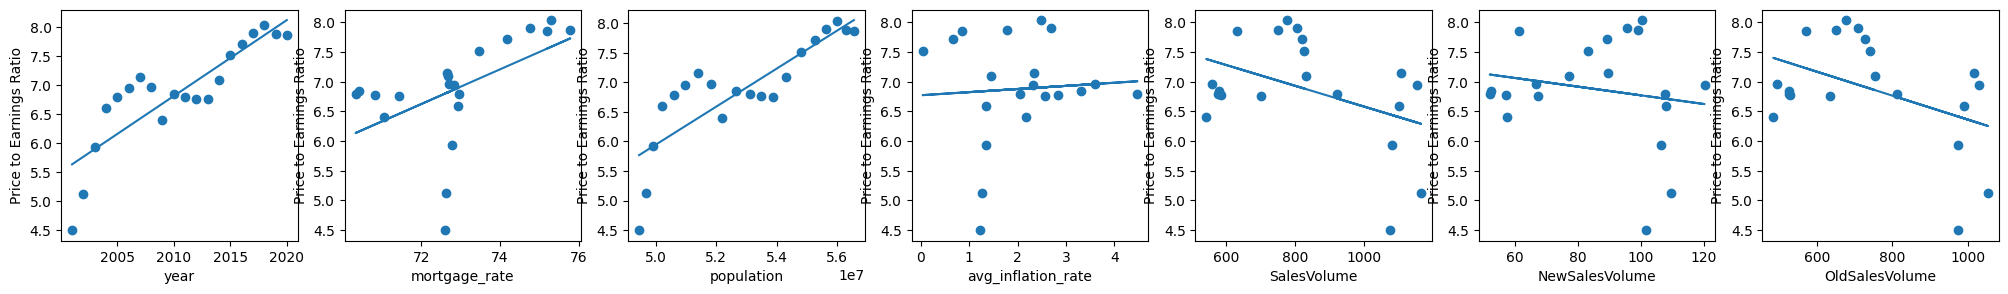

W


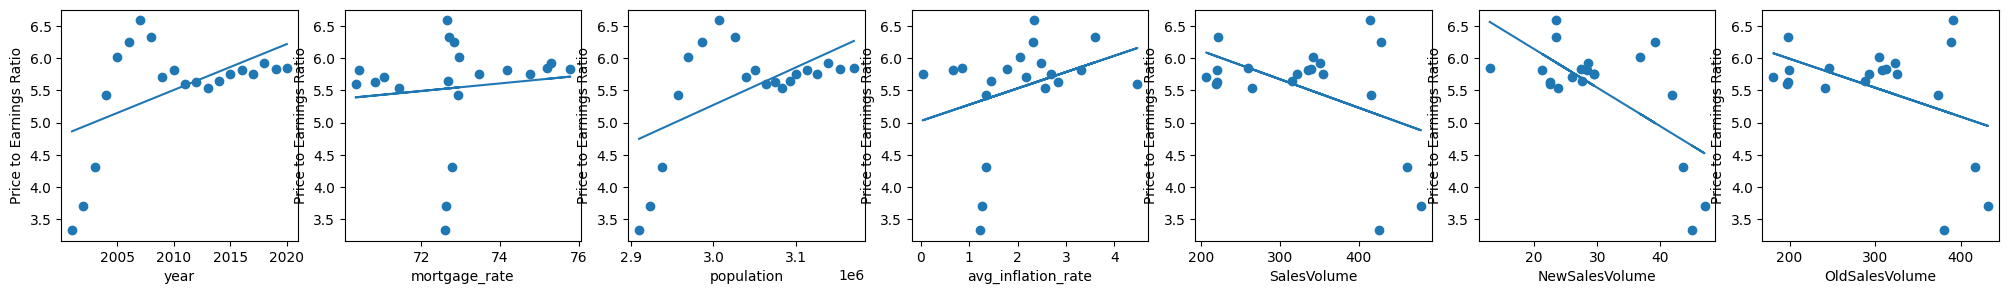

In [ ]:
for i, country in enumerate(countries):
    fig, axes = plt.subplots(1, 7, figsize=(25, 3))

    # Get labels for country
    countryDf = (df.loc[df["country"] == country]).drop("country", axis=1)
    affordData = countryDf.pop("affordability")

    print(country)

    # Plot all scatters
    for j, col in enumerate(countryDf.columns):
        colData = np.array(countryDf[col])

        # Get LOBF
        a, b = np.polyfit(colData, affordData, 1)

        # Plot
        axes[j].scatter(colData, affordData)
        axes[j].set_xlabel(col)
        axes[j].set_ylabel("Price to Earnings Ratio")
        axes[j].plot(colData, (a*colData) + b)
    plt.show()

Linear model predictions over time

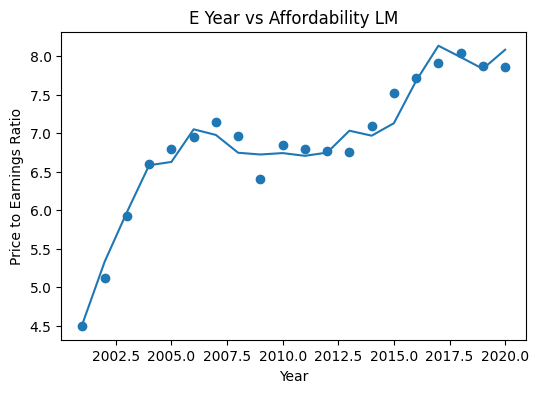

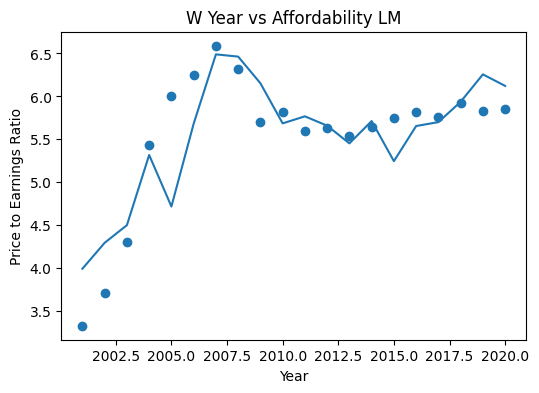

In [ ]:
for i, country in enumerate(countries):
    fig, axes = plt.subplots(figsize=(6, 4))

    # Get labels for country
    countryDf = (df.loc[df["country"] == country]).drop("country", axis=1)
    affordData = countryDf.pop("affordability")

    # Model predictions
    preds = lms[i].predict(countryDf)

    # Plot all scatters
    colData = np.array(countryDf["year"]).reshape(-1, 1)

    # Plot
    axes.scatter(colData, affordData)
    axes.set_title(country+" Year vs Affordability LM")
    axes.set_xlabel("Year")
    axes.set_ylabel("Price to Earnings Ratio")
    axes.plot(colData, preds)
    plt.show()

### LASSO Regression with CV to choose alpha

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

lassoModels = []
lassoXScalers = []
lassoYScalers = []
for country in countries:
    # Get Data for Country
    countryData = df.loc[df["country"] == country].drop("country", axis=1)
    countryYs = countryData.pop("affordability")
    countryXs = countryData

    # Scale and log scalers
    xScaler = MinMaxScaler().fit(countryXs)
    yScaler = MinMaxScaler().fit(np.array(countryYs).reshape(-1, 1))
    scaledXs = xScaler.transform(countryXs)
    scaledYs = yScaler.transform(np.array(countryYs).reshape(-1, 1))
    lassoXScalers.append(xScaler)
    lassoYScalers.append(yScaler)

    # Do CV to find best alpha
    params = {"alpha": [0.001, 0.01, 0.1, 0.5, 1]}
    lasso = Lasso()
    lassoCV = GridSearchCV(lasso, params, cv=len(scaledXs), scoring="neg_mean_squared_error")
    lassoCV.fit(scaledXs, scaledYs)

    bestLasso = lassoCV.best_estimator_
    lassoModels.append(lassoCV.best_estimator_)

    # Logging
    print(country)
    print("r^2: "+str(bestLasso.score(scaledXs, scaledYs)))
    print(list(countryData.columns))
    print("Coefficents: "+str(bestLasso.coef_))
    print("Alpha: "+str(lassoCV.best_params_))
    print()

E
r^2: 0.7862053587187288
['year', 'mortgage_rate', 'population', 'avg_inflation_rate', 'SalesVolume', 'NewSalesVolume', 'OldSalesVolume']
Coefficents: [ 7.50574723e-01  2.39372373e-02 -0.00000000e+00  1.94100932e-01
  1.05312256e-05  1.68566017e-01  0.00000000e+00]
Alpha: {'alpha': 0.001}

W
r^2: 0.4308474946670756
['year', 'mortgage_rate', 'population', 'avg_inflation_rate', 'SalesVolume', 'NewSalesVolume', 'OldSalesVolume']
Coefficents: [ 0.          0.          0.04641058  0.         -0.         -0.44126314
 -0.        ]
Alpha: {'alpha': 0.01}



Plot LASSO

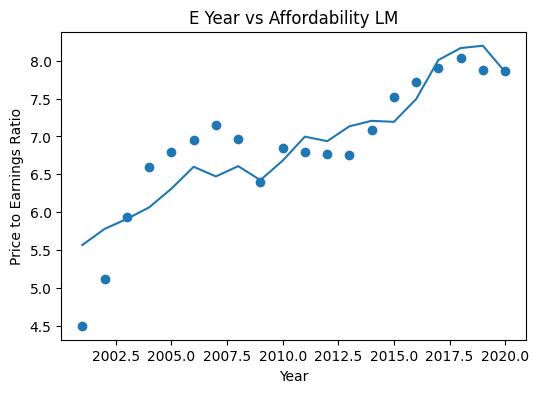

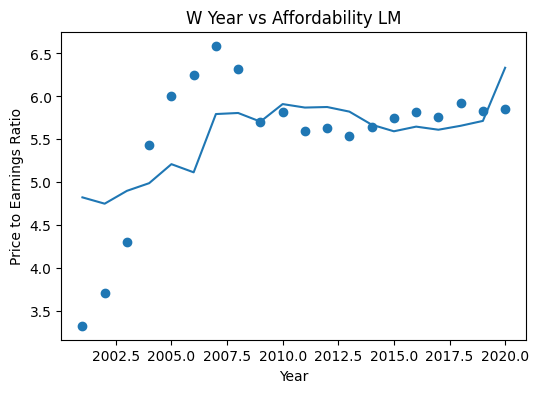

In [ ]:
for i, country in enumerate(countries):
    fig, axes = plt.subplots(figsize=(6, 4))

    # Get labels for country
    countryDf = (df.loc[df["country"] == country]).drop("country", axis=1)
    affordData = countryDf.pop("affordability")

    # Model predictions
    scaledXs = lassoXScalers[i].transform(countryDf)
    scaledPreds = lassoModels[i].predict(scaledXs)
    preds = lassoYScalers[i].inverse_transform(scaledPreds.reshape(-1, 1))

    # Plot all scatters
    colData = np.array(countryDf["year"]).reshape(-1, 1)

    # Plot
    axes.scatter(colData, affordData)
    axes.set_title(country+" Year vs Affordability LM")
    axes.set_xlabel("Year")
    axes.set_ylabel("Price to Earnings Ratio")
    axes.plot(colData, preds)
    plt.show()